In [ ]:
!pip install noisereduce
!pip install librosa

In [ ]:
import librosa
import librosa.display
import os
import noisereduce as nr
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from collections import defaultdict
import soundfile as sf
import IPython.display as ipd

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
SAMPLING_RATE = 16000
AUDIO_DURATION = 3000 #in seconds
FRAME_ACCURACY = 0.99
SPLIT_SIZE = 10000
MAX_SAMPLES = 0
K = int(AUDIO_DURATION*SAMPLING_RATE*FRAME_ACCURACY/SPLIT_SIZE)*SPLIT_SIZE
N = int(K/SPLIT_SIZE)

In [ ]:
def is_overlap(cstart_time, cend_time, start_time, end_time):
  if(cstart_time > end_time):
    return False
  if(cend_time < start_time):
    return False
  if(start_time > cstart_time and end_time < cend_time ):
    return True
  if(start_time > cstart_time):
    overlap = start_time - cstart_time
    if(overlap > 0.50 * (start_time - cend_time)):
      return True
    else:
      return False
  if(end_time < cend_time):
    overlap = cend_time - end_time
    if(overlap > 0.50 * (start_time - cend_time)):
      return True
    else:
      return False
  
  return True

In [ ]:
def one_hot_enc(cl_name):
  if(cl_name == 'music'):
    return np.array([0,1,0])
  elif(cl_name == 'speech'):
    return np.array([1,0,0])
  else:
    return np.array([0,0,1])

In [ ]:
def load_audio(filename, cls, Fs = 16000):
    # Return bins of size of 1000 corresponding to 
    x, _ = librosa.load(filename, sr=Fs)
    x = x[:SAMPLING_RATE*AUDIO_DURATION+10]
    print(len(x))
    # x = nr.reduce_noise(x, Fs)
    x = np.reshape(x[:K], (-1,SPLIT_SIZE))
    labels = np.zeros((N,3))
    for index, sub_audios in enumerate(x):
      class_assigned = False
      for tup in enumerate(cls):
        if(is_overlap(tup[1][0], tup[1][1], index*SPLIT_SIZE/K, (index+1)*SPLIT_SIZE/K)):
          labels[index] = one_hot_enc(tup[1][2])
          class_assigned = True
          break
      if(class_assigned == False):
          labels[index] = one_hot_enc('silence')
    
    return labels, x

In [ ]:
def load_data(foldername, labelsfile, Fs=16000):

  files = os.listdir(foldername)
  df = pd.read_csv (labelsfile, usecols=['filename','onset','offset','class'])
  labels_data = df.to_numpy()
  data = dict()
  labels = defaultdict(list)
  
  for entry in labels_data:
    # print(entry[0])
    # print((entry[1],entry[2],entry[3]))
    labels[entry[0]].append((entry[1],entry[2],entry[3]))
  
  labels_list = []
  data_list = []

  for wav_file in files:
    ls, audio = load_audio(foldername+"/"+wav_file, labels[wav_file[:-4]], Fs)
    labels_list.append(ls)
    data_list.append(audio)

  labels_final = np.array(labels_list)
  data_final = np.array(data_list)
  labels_final = labels_final.reshape(N*len(files), 3)
  data_final = data_final.reshape(N*len(files), SPLIT_SIZE)
  print(labels_final.shape)
  print(data_final.shape)
  return labels_final, data_final

In [ ]:
def reverse_one_hot(ohv):
  if(ohv[1] == 1):
    return "music"
  elif(ohv[0] == 1):
    return "speech"
  else:
    return "silence"

In [ ]:
def save_data(train_labels, train_audios):
  for i in range(len(train_audios)):
    print(reverse_one_hot(train_labels[i]))
    sf.write('/content/drive/MyDrive/val_set/split_wavs/'+str(i)+'.wav', train_audios[i], 16000)

In [ ]:
train_labels, train_audios = load_data('/content/drive/MyDrive/val_set/speech_and_music', '/content/drive/MyDrive/val_set/labels_new.csv')

48000010
48000010
(9504, 3)
(9504, 10000)


In [ ]:
fr = range(len(train_audios))
tm = librosa.frames_to_time(fr)

In [ ]:
for lab in train_labels:
  print(reverse_one_hot(lab))

In [ ]:
print(train_audios.shape)
print(train_labels.shape)

(9504, 10000)
(9504, 3)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(train_audios, train_labels, train_size=0.8, random_state=42)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(7603, 10000)
(7603, 3)
(1901, 10000)
(1901, 3)


Using RMS Energy

In [ ]:
# Defining the parameters for RMS Energy Extraction
FRAME_LENGTH = 1024
HOP_LENGTH = 512

In [ ]:
from tqdm import tqdm

In [ ]:
def get_rms(X):
  X_rms = []
  for sample in tqdm(X):
    rms_energy = librosa.feature.rms(sample, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]  
    X_rms.append(rms_energy)
  X_rms = np.array(X_rms)
  print(X_rms.shape)
  return X_rms

In [ ]:
A = get_rms(X_train)
B = get_rms(X_test)

100%|██████████| 7603/7603 [00:01<00:00, 4532.29it/s]


(7603, 20)


100%|██████████| 1901/1901 [00:00<00:00, 5084.07it/s]

(1901, 20)


In [ ]:
print(A.shape)
print(B.shape)

(7603, 20)
(1901, 20)


Dense Neural Network (1 Layer)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(), 
                                    tf.keras.layers.Dense(10, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(3, activation=tf.nn.softmax)])

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.fit(A, Y_train, epochs=10)

Epoch 1/10
238/238 [==============================] - 1s 2ms/step - loss: 0.8760 - accuracy: 0.4924
Epoch 2/10
238/238 [==============================] - 0s 2ms/step - loss: 0.7193 - accuracy: 0.5498
Epoch 3/10
238/238 [==============================] - 0s 2ms/step - loss: 0.6769 - accuracy: 0.6184
Epoch 4/10
238/238 [==============================] - 0s 2ms/step - loss: 0.6542 - accuracy: 0.6412
Epoch 5/10
238/238 [==============================] - 0s 1ms/step - loss: 0.6366 - accuracy: 0.6570
Epoch 6/10
238/238 [==============================] - 0s 1ms/step - loss: 0.6212 - accuracy: 0.6838
Epoch 7/10
238/238 [==============================] - 0s 2ms/step - loss: 0.6070 - accuracy: 0.6959
Epoch 8/10
238/238 [==============================] - 0s 1ms/step - loss: 0.5950 - accuracy: 0.7088
Epoch 9/10
238/238 [==============================] - 0s 1ms/step - loss: 0.5850 - accuracy: 0.7195
Epoch 10/10
238/238 [==============================] - 0s 1ms/step - loss: 0.5759 - accuracy: 0.7239

In [ ]:
model.evaluate(B, Y_test)

60/60 [==============================] - 0s 1ms/step - loss: 0.5728 - accuracy: 0.7286


[0.5728276968002319, 0.7285639047622681]

Using Zero Crossing Rate


In [ ]:
def get_zcr(X):
  X_zcr = []
  for sample in tqdm(X):
    zcr_total = librosa.feature.zero_crossing_rate(sample, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]  
    X_zcr.append(zcr_total)
  X_zcr = np.array(X_zcr)
  print(X_zcr.shape)
  return X_zcr

In [ ]:
A = get_zcr(X_train)
B = get_zcr(X_test)

100%|██████████| 7603/7603 [00:03<00:00, 2218.69it/s]


(7603, 20)


100%|██████████| 1901/1901 [00:00<00:00, 2630.46it/s]

(1901, 20)


In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(), 
                                    tf.keras.layers.Dense(20, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(20, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(3, activation=tf.nn.softmax)])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.fit(A, Y_train, epochs=1000)

In [ ]:
model.evaluate(B, Y_test)

60/60 [==============================] - 0s 1ms/step - loss: 0.4551 - accuracy: 0.8075


[0.45508310198783875, 0.8074697256088257]

Using MFCC features

In [ ]:
def get_mfcc(X):
  X_mfcc = []
  for sample in tqdm(X):
    mfcc_sample = librosa.feature.mfcc(sample, n_mfcc = 20, sr=SAMPLING_RATE, n_fft = FRAME_LENGTH, hop_length=HOP_LENGTH)[0]  
    X_mfcc.append(mfcc_sample)
  X_mfcc = np.array(X_mfcc)
  print(X_mfcc.shape)
  return X_mfcc

In [ ]:
A = get_mfcc(X_train)
B = get_mfcc(X_test)

100%|██████████| 7603/7603 [00:41<00:00, 182.73it/s]


(7603, 20)


100%|██████████| 1901/1901 [00:10<00:00, 182.22it/s]

(1901, 20)


In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(), 
                                    tf.keras.layers.Dense(20, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(20, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(3, activation=tf.nn.softmax)])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.fit(A, Y_train, epochs=1000)

In [ ]:
model.evaluate(B, Y_test)

60/60 [==============================] - 0s 1ms/step - loss: 0.4845 - accuracy: 0.8790


[0.4844619631767273, 0.8790110349655151]

SIGNAL PROCESSING BASED METHODS


In [ ]:
speech_audio, _ = librosa.load('/content/drive/MyDrive/val_set/speech_and_music/speech_long.wav', sr=16000, offset=1000, duration=60)
music_audio, _  = librosa.load('/content/drive/MyDrive/val_set/speech_and_music/music_long.wav', sr=16000, duration=60)
# speech_audio = speech_audio[48074313:53074313]
# music_audio = music_audio[43074313:48074313]

In [ ]:
ipd.Audio(speech_audio, rate=16000)

In [ ]:
ipd.Audio(music_audio, rate=16000)

In [ ]:
print(speech_audio.shape)
print(music_audio.shape)

(960000,)
(960000,)


In [ ]:
# Extracting RMS Energy using librosa
FRAME_LENGTH = 1024
HOP_LENGTH = 512
rms_speech = librosa.feature.rms(speech_audio, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
rms_music = librosa.feature.rms(music_audio, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

In [ ]:
print(rms_speech.shape)

(1876,)


Text(0.5, 1.0, 'Music')

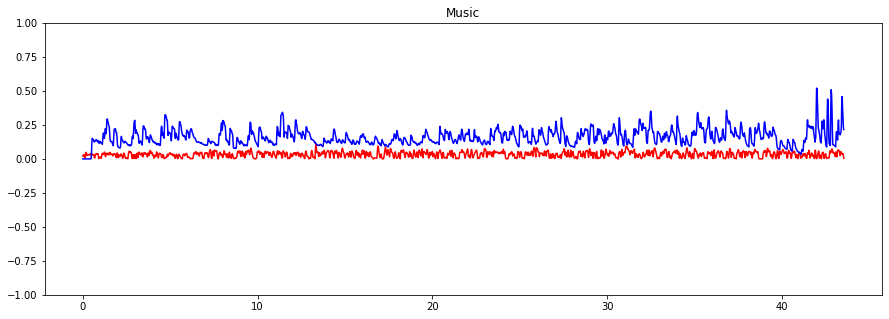

In [ ]:
# Plot the RMS energy for music and speech
frames = range(len(rms_speech))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

plt.figure(figsize=(15,5))
# ax = plt.subplot(2,1,1)
# librosa.display.waveplot(speech_audio, alpha=0.5)
plt.plot(t, rms_speech, color='r')
plt.ylim(-1,1)
plt.title("Speech")

# plt.subplot(2,1,2)
# librosa.display.waveplot(music_audio, alpha=0.5)
plt.plot(t, rms_music, color='b')
plt.ylim(-1,1)
plt.title("Music")


In [ ]:
zcr_speech = librosa.feature.zero_crossing_rate(speech_audio, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
zcr_music = librosa.feature.zero_crossing_rate(music_audio, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

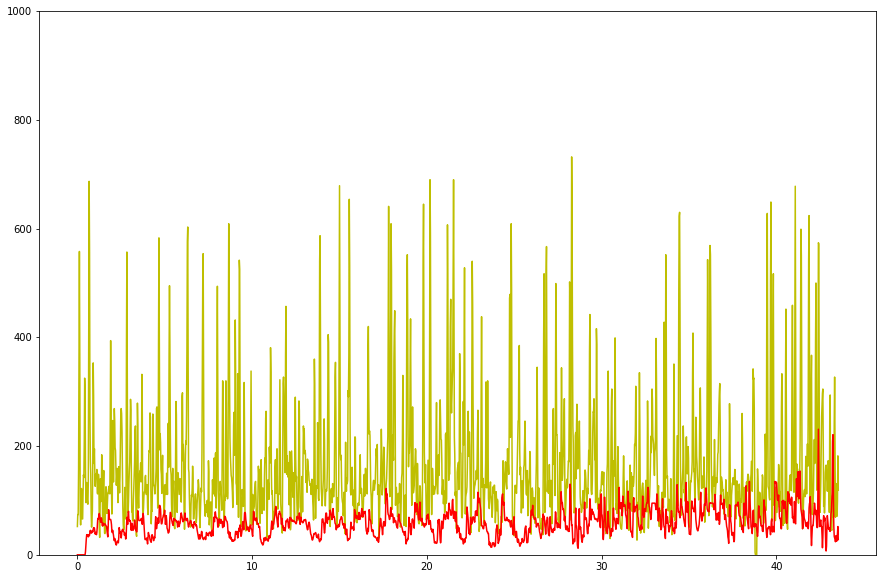

In [ ]:
plt.figure(figsize=(15, 10))

plt.plot(t, zcr_speech * FRAME_LENGTH, color="y")
plt.plot(t, zcr_music * FRAME_LENGTH, color="r")
plt.ylim(0, 1000)
plt.show()

In [ ]:
bandwidth_speech = librosa.feature.spectral_bandwidth(y=speech_audio, n_fft=4096, hop_length=HOP_LENGTH)[0]
bandwidth_music = librosa.feature.spectral_bandwidth(y=music_audio, n_fft=4096, hop_length=HOP_LENGTH)[0]

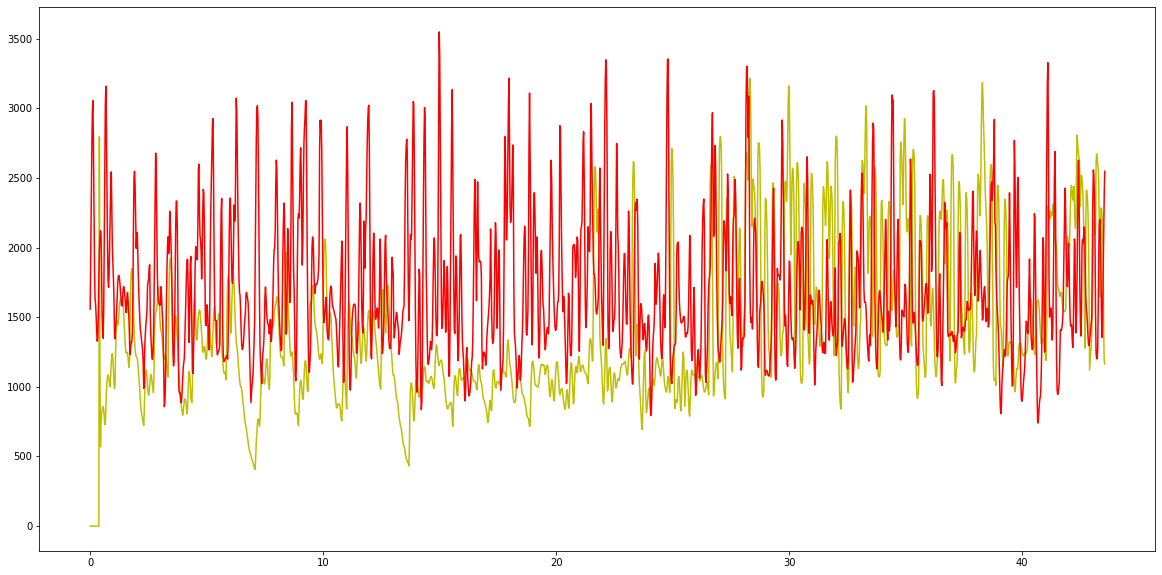

In [ ]:
plt.figure(figsize=(20, 10))

plt.plot(t, bandwidth_music, color="y")
plt.plot(t, bandwidth_speech, color="r")
# plt.ylim(0,)
plt.show()